# Scouting Bandits (SB)

**input:** exploration time $T_0$, grid size $K$, and K-armed bandit algorithm $\alpha$

**initialization**: $q_k$ &larr; $\frac{k}{K+1}$ , $\hat{F_k}$ &larr; 0, $\hat{G_k}$ &larr; 0, for all k $\in [K]$

**for** t=1,2,...,$T_0$ **do**

&emsp;draw $U_t$ from $[0,1]$ uniformly at random;

&emsp;post price $U_t$ and observe feedback $(I_{S_t \leq U_t} , I_{U_t \leq B_t})$

&emsp;let 
$\hat{F_k}$ &larr;  $\hat{F_k} + \frac{1}{T_0}*I_{q_k \leq U_t \leq B_t}$ and 
$\hat{G_k}$ &larr;  $\hat{G_k} + \frac{1}{T_0}*I_{S_t \leq U_t \leq q_k}$

**end**

**for** t=$T_0+1,T_0+2,...$ **do**

&emsp; generate the next arm $I_t$ with $\alpha$

&emsp; post price $q_{I_t}$ and observe $(I_{S_t \leq q_{I_t}} , I_{q_{I_t} \leq B_t})$

&emsp; feed $\alpha$ the reward 
$Z_t(I_t)$ &larr; $(I_{S_t \leq q_{I_t}} * \hat{F_{I_t}}) +  (I_{q_{I_t} \leq B_t} * \hat{G_{I_t}})$

**end**

## REGRET

$R_T(SB) \leq T_0 + (\frac{4M}{K+1} + \frac{\sqrt{2\pi}}{T_0})(T-T_0) + R_{T-T_0}(\alpha)$

* The seller and buyer are independent (iv) and have densities bounded by some constant M.

* The regret of Scouting Bandits (SB) run with parameters $T_0, K, \alpha$ satisfies, for any time horizon $T_0 \leq T$


In particular, if for each K we have a bandit algorithm $\alpha^K$ with K arms s.t $R_T(\alpha) = O(\sqrt{K t})$
then tuning the parameters $T_0 = [T^{\frac{2}{3}}]$ and $K = [T^{\frac{1}{3}}]$ gives the best regret $R_T(SB) = O(M*T^{\frac{2}{3}})$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import pandas as pd
%run distributions.ipynb
%run grafici_bandits.ipynb

In [4]:
def print_all_exploration_phase(t, fdb_s, fdb_b):
    print("\nRound: #", t)
    print("fdb_s: ",fdb_s,"\tfdb_b: ",fdb_b)

In [5]:
def print_all_bandit_phase(t, q_arm, fdb_s, fdb_b, F_arm, G_arm, reward):
    print("\nRound: ", t)
    print("q[arm]: ", q_arm)
    print("fdb_s_bandit: ", fdb_s, "\tfdb_b_bandit: ", fdb_b,)
    print("F_arm: ",  F_arm, "\tG_arm: ", G_arm, "")
    print("Reward: ", reward)

In [6]:
def observe_feedback(A,B):
    return 1 if(A <= B) else 0

# ALGORITMI BANDITI

## Epsilon greedy algorithm

video: https://www.youtube.com/watch?v=EjYEsbg95x0

lezione UPS: file:///C:/Users/lorenzo/Downloads/Slides_MAB_RL.pdf

paper: https://arxiv.org/pdf/2101.01086.pdf

Multi-Armed Bandits: Epsilon-Greedy Algorithm: https://medium.com/analytics-vidhya/multi-armed-bandits-part-1-epsilon-greedy-algorithm-with-python-code-534b9e2abc9

In [9]:
#K = num of arms
#epsilon_t = 1/i_round
#C = consant
#t = round
#delta = diff between mean reward
#val_t in [0,1]
#if val < epsilon then choose at random
#if val >= epsilon then choose empirically

def epsilon_greedy_bandit(K, i_round, rewards):
    
    #Draw once each arm
    if(i_round < K): return i_round
    
    #At each time t, With probability 1 − ε select the arm with best empirical reward
    epsilon = 1/i_round #cambia nel tempo
    val = np.random.random()
    
    if(val >= 1-epsilon): pos = rewards.index(max(rewards))
    #Otherwise, select it uniformly in {1 . . . K}
    pos = np.random.randint(0,K)
    return pos

The regret of GREEDY verifies for all ε > 0:

$R_T <= T^{(-N_\epsilon * \frac{\epsilon^2}{2})} + 3\epsilon T + \frac{6}{K} + \sum_{k=1}^K \Delta_k$

Where:
* $R_T = E[\sum_{t=1}^T (\mu^* - X_t)] = T\mu^* - E[\sum_{t=1}^{T} \mu_{A_t}] = \sum_{k=1}^{K}(\Delta_k E [N_k(T)])$
* Let µ1, . . . , µK denote the mean rewards of arms, and $µ^{*}:= max_k∈[K] µ_k$ be the
best mean reward.
* $N_\epsilon$ denotes the number of $\epsilon$-oprimal arms
* arm k is ε-optimal for some ε > 0 if f $µ_k ≥ µ^{*}ε$
* $\Delta_k = \mu^* - \mu_k$

## THOMPSON

[Multi-Armed Bandits: Thompson Sampling Algorithm](https://towardsdatascience.com/multi-armed-bandits-thompson-sampling-algorithm-fea205cf31df)

[video](https://www.youtube.com/watch?v=yQwJiFFIgjA)


Nel Thompson sampling algorithm per ogni arm prendiamo un valore all'interno di una distribuzione beta data da:

 * (A) quante volte abbiamo ottenuto una reward dopo aver scelto quell'opzione
 * (B) quante volte NON abbiamo ottenuto una reward dopo aver scelto quell'opzione
 * scegliamo l'arm che ha valore maggiore
 
In una distribuzione beta più il valore di A è grande rispetto a B, più il valore che otterremo sarà vicino ad 1. Al contrario, maggiore è il valore di B rispetto ad A e più il valore si avvicinerà ad 0. In questo modo, un'opzione che ha valore beta più alto sarà quella che ho scelto più spesso perché ha restituito una ricompensa più spesso.

 **ALGORITMO**


**input:** num of arms K, num of rounds n, dictionary i:s dict_i_s, dictionary i:r dict_i_r
 
**initialization:** pos &larr; 0, max_val &larr; 0

**for k,v in dictionary**:
 
 &emsp; alpha = num. of times k has been choosen
 
 &emsp; beta = num. of times k has been choosen and has NOT received a reward
 
 &emsp; draw value from beta distribution B(alpha, beta)
 
 &emsp; use said value to get the best arm to choose
 
 &emsp; return arm
 
**end**

In [12]:
# K = num arms
# n = num round
# dict_i_s = dizionario arm : #volte scelto
# dict_i_r = dizionario arm : #numero volte ricompensa != 0
# num_cifre = num cifre dopo virgola

def thompson_algorithm(K, n, dict_i_s, dict_i_r, num_cifre):
    pos = 0
    max_val = 0
    
    #creiamo distribuzione beta avendo:
    # a = numero di reward ottenute per ogni arm
    # b = numero di volte in cui non abbiamo avuto reward (numero di round fino ad ora - a)
    # DOPO AVER SCELTO quell'opzione
    
    for key, val in dict_i_s:
        alpha = dict_i_s.get(i) #numero di reward
        beta = dict_i_r.get(i)  #numero volte senza reward
        
        val = np.around(np.random.beta(alpha, beta, n), num_cifre) #valore dell'arm
        if(val > max_val): 
            max_val = val
            pos = i
        
    
    return pos

## MOTS (Minimax Optimal Thompson Sampling)

[paper](file:///Users/lorenzomazzi/Desktop/Uni/Tirocinio/TEORIA/MOTS-%20Minimax%20Optimal%20Thompson%20Sampling.pdf)

MOTS achieves O($\sqrt{KT}$) problem-independent regret.

Furthermore, we show that when the reward distributions are Gaussian, a variant of MOTS with clipped Rayleigh distributions, namely MOTS-J, can simultaneously achieve asymptotic and minimax optimal regret bounds.

Our experiments demonstrate the superiority of MOTS over the state-of-the-art bandit algorithms such as UCB (Auer et al., 2002a), MOSS (Audibert and Bubeck, 2009), and TS (Thompson, 1933) with Gaussian priors.

Nomenclatura:
* A random variable X is said to follow a 1-subGaussian distribution, if it holds that:
    
    $E[e^{\lambda X - \lambda E[X]}] <= e^{(\frac{\lambda^2}{2})}$ &emsp; $ $for all $\lambda \in R$
    
    
* We let T be the total number of time steps
* K be the number of arms -> [K] = {1, 2, · · · , K}.
* We use ∆i to denote the gap between arm_1 and arm_i, i.e., ∆i :=μ1−μi,i∈[K]\{1}
* $T_i(t)=\sum_{j=1}^t I\lbrace A_j =i \rbrace $ &emsp;  as the number of times that arm i has been played at time step t
* $\hat{\mu_i}(t) = \sum_{j=1}^t I\lbrace A_j =i \rbrace * \frac{r_j}{T_i(t)}$&emsp;as the average reward for pulling arm i up to time t, where rj is the reward received by the algorithm
at time j.


**ALGORITMO MOTS**

**Input:** Arm set [K].

**Initialization:** Play arm once and set $T_i$(K + 1) = 1; let $μ_i$(K + 1) be the observed reward of playing arm i

**for t=K+1,K+2,···,T do**

&emsp;**For all i ∈ [K]** sample $θ_i(t)$ independently from $D_i(t)$

&emsp;Play arm At = $argmax_{i\in [K]} θ_i(t)$ and observe the reward $r_t$

&emsp;**For all i ∈ [K]** calculate:

&emsp;&emsp; $\hat{\mu_i}(t+1) = \frac{T_i(t) * \hat{\mu_i}(t) + r_t * I\lbrace{i = A_t}\rbrace} {T_i(t) I\lbrace{i = A_t}\rbrace}$ &larr; aggiorna reward

&emsp;For all i∈[K]: Ti(t+1)=Ti(t)+1{i=At} 

**end for**


### Distribuzione gaussiana

$N(\mu, \rho^2)$= $N(\hat{\mu}_i(t), \frac{1}{\rho*T_i(t)})$

* where  $\rho \in (1/2, 1)$ is a tuning parameter
* return $\tilde{\theta}_i(t)$

La funzione sample_theta prende in input la media u e la varianza della distribuzione Gaussiana desiderata e restituisce un campione campionato dalla distribuzione Gaussiana $N(\hat{\mu}_i(t), \frac{1}{\rho*T_i(t)})$. La funzione utilizza la funzione np.random.normal del modulo NumPy per generare un campione dalla distribuzione Gaussiana standard N(0,1) e lo trasforma per ottenere un campione dalla distribuzione Gaussiana desiderata.

#### ATTENZIONE -> IL VALORE FINALE DI THETA è:


$\theta_i(t) = min \lbrace \tilde{\theta}_i(t), \tau_i(t) \rbrace$

dove:

$\tau_i(t)  = \hat{\mu}_i(t) + \sqrt{\frac{\alpha}{T_i(t)} *\log^+(\frac{T}{KT_i(t)})}$

dove:

$\log^+(x) = max \lbrace 0, log(x) \rbrace$ &emsp; $\alpha > 0 $&larr; costante

In [15]:

# funzione log^+
def positive_log(value):
    val = math.log(value)
    return max(val, 0)

#ottieni campione da distribuzione gaussiana N
def sample_theta(media, varianza):
    z = np.random.normal(loc=0, scale=1)
    theta = media + z / np.sqrt(varianza) #rappresenta il campionamento di un'istanza casuale dalla distribuzione Gaussiana 
    return theta


def mots_algorithm(K, n, dict_i_s, rewards):
    
    alpha = 0.1 #costante > 0
    
    list_thetas = [] #lista con valori finali di theta
    
    #In the first K time steps, TS plays each arm i ∈ [K] once,
    #and updates the average reward estimation μ_i(K + 1) for each arm i.
    
    if(n < K): return n
    
    # At step t, the algorithm samples instances θi(t) independently 
    # from distribution Di(t), forall i ∈ [K]. 
    
    for i in dict_i_s:
        #trovare valore T_i(t)
        #numero di volte in cui il braccio i è stato giocato
        
        T_i = dict_i_s[i]
        
        #troviamo istanza di theta
        #prima però generiamo tutti i valori necessari: media e varianza
        
        #media
        media = rewards[i] #media empirica -> ricompensa dell'i-esimo braccio
        
        #varianza
        rho = np.random.uniform(0.5, 1)
        varianza = 1 / (rho * T_i)
        
        #calcoliamo tilde_theta usando la funzione sample_theta
        tilde_theta_i_t = sample_theta(media, varianza)
        
        #calcoliamo tau_i_t
        tau_i_t = rewards[i] + math.sqrt( (alpha / T_i) * positive_log( n / (K * T_i)) )
        
        #verifichiamo quale abbiamo il valore minore e inseriamola nella lista
        list_thetas.append(min(tilde_theta_i_t, tau_i_t))
        
    #troviamo braccio -> ovvero indice della lista coi valori finali di theta con valore massimo
    pos = list_thetas.index(max(list_thetas))
    
    #il resto dell'algoritmo indica semplicemente di aggiornare i valori della reward e di s
    #per il braccio scelto i
    
    return pos

### MOTS-J (Minimax Optimal Thompson Sampling)

Come MOTS solo che la distribuzione gasussiana ha un valore rho sempre pari a 1

In [17]:

# funzione log^+
def positive_log(value):
    val = math.log(value)
    return max(val, 0)

#ottieni campione da distribuzione gaussiana N
def sample_theta(media, varianza):
    z = np.random.normal(loc=0, scale=1)
    theta = media + z / np.sqrt(varianza) #rappresenta il campionamento di un'istanza casuale dalla distribuzione Gaussiana 
    return theta


def mots_j_algorithm(K, n, dict_i_s, rewards):
    
    alpha = 0.1 #costante > 0
    
    list_thetas = [] #lista con valori finali di theta
    
    #In the first K time steps, TS plays each arm i ∈ [K] once,
    #and updates the average reward estimation μ_i(K + 1) for each arm i.
    
    if(n < K): return n
    
    # At step t, the algorithm samples instances θi(t) independently 
    # from distribution Di(t), forall i ∈ [K]. 
    
    for i in dict_i_s:
        #trovare valore T_i(t)
        #numero di volte in cui il braccio i è stato giocato
        
        T_i = dict_i_s[i]
        
        #troviamo istanza di theta
        #prima però generiamo tutti i valori necessari: media e varianza
        
        #media
        media = rewards[i] #media empirica -> ricompensa dell'i-esimo braccio
        
        #varianza
        varianza = 1 / (T_i)
        
        #calcoliamo tilde_theta usando la funzione sample_theta
        tilde_theta_i_t = sample_theta(media, varianza)
        
        #calcoliamo tau_i_t
        tau_i_t = rewards[i] + math.sqrt( (alpha / T_i) * positive_log( n / (K * T_i)) )
        
        #verifichiamo quale abbiamo il valore minore e inseriamola nella lista
        list_thetas.append(min(tilde_theta_i_t, tau_i_t))
        
    #troviamo braccio -> ovvero indice della lista coi valori finali di theta con valore massimo
    pos = list_thetas.index(max(list_thetas))
    
    #il resto dell'algoritmo indica semplicemente di aggiornare i valori della reward e di s
    #per il braccio scelto i
    
    return pos

## MOSS (Minimax Optimal Strategy in the Stochastic Case)

[Paper](file:///Users/lorenzomazzi/Desktop/Uni/Tirocinio/TEORIA/MOSS_algo_for_SB.pdf)

Dal paper di colomboni:

In particular, if for each 𝐾 we have a bandit algorithm 𝛼𝐾 over 𝐾 arms such that R𝜏 (𝛼𝐾 ) = O 𝐾𝜏 (e.g., if 𝛼𝐾 is the MOSS algorithm over 𝐾 arms, then tuning the parameters $T_0 := [T ^{2/3}]$ and $𝐾 := [T^{1/3}]$ gives the regret bound:

$R_t(SB) = O (MT^2/3)$


Algoritmo MOSS per la scelta delle arms:

Avendo:

* $\hat{X}_{i,s}$: be the empirical mean (media aritmetica) of arm *i* after *s* draws of this arm.
* Ti(t): denote the number of times we have drawn arm i on the first t rounds
* n: n ≥ K be the time horizon.
* K: K ≥ 2 be the number of actions (or arms) 


* *Each arm has an index measuring its performance, and at each round, we choose the arm having the highest index.*

* *The index of an arm that has been drawn more than n/K times is simply the empirical mean of the rewards obtained from the arm*

**ALGORITMO**


**input:** num of arms K, num of rounds n, dictionary i:s dict_i_s, dictionary i:r dict_i_r
 
**initialization:** pos &larr; 0, max index &larr; 0
 
**for i = 0,1,...,K:**
 
 &emsp; use each arm once
 
 **end**
 
**for: i = K, K+1, ..., T:**
 

 **for an arm i, define its index $B_{i,s}$ by:**

&emsp;$B_{i,s}$ = $\hat{X}_{i,s}$+$\sqrt{\frac{max(log(\frac{n}{Ks}),0)}s}$

 **for s ≥ 1 and Bi,0 = + $\infty$:**

&emsp; At time t, draw an arm maximizing $B_{i,Ti(t−1)}$

**end**


Regret che mi aspetto: achieving a $\sqrt{nK}$ regret in the worst case
        

In [19]:
#ciclo for da 0 a K per calcolare B_i,s
#dopo averli calcolati prendere quello che massimizza B_i,Ti(t-1)
#map_i_s è una mappa che per ogni arm indica quante volte è stato selezionato fino ad adesso (inizialmente vuota)
#n = #round attualmente avuti


import math
def moss_algorithm(K, n, dict_i_s, rewards):
    
    pos = 0; #braccio da restituire (quello scelto)
    max_index = 0; #massimo valore b attualemente calcolato
    
    if(n < K): return n   # se il round attuale è minore del numero di braccia allora restituiamo quella pari al
                          # round in cui ci troviamo, altrimenti userebbe sempre la prima (n = final_arm = 0)
    
    for key in dict_i_s:
        #se siamo qua è perchè ogni braccio è stato usato almeno una volta
            i = key
            s = dict_i_s.get(i)
            
            x_i_s = rewards[i]               #media empirica -> ricompensa dell'i-esimo braccio
            
            log = math.log(n/(K*s))         #calcolo log
            b_i_s = log if log > 0 else 0   #verifico se prendere valore log oppure 0 (valore index)
            b_i_s = b_i_s/s + x_i_s         #calcolo valore finale di b_i_s (index)
            
            if(b_i_s > max_index):
                pos = i   #aggiorno arm da restituire
                max_index = b_i_s   #aggiorno max valore index
    
    return pos

# ALGORITMO

### ALGORITMO SB CON EPSILON GREEDY

In [22]:
def SB_E_GREEDY(T_0, K, num_cifre, S_D, B_D, type_distribution, graph_values):
    
    #inizializzazione
    q = [(k/(K + 1)) for k in range(0,K)] # K = {0,...,K}
    feedback_s,feedback_b = [],[]
    F,G = [0] * K,[0] * K #array di K elementi tutti di valore 0
    
    #parte di esplorazione
    for t in range(0, T_0):
        U_t = np.random.random()   #prezzo 
        fdb_s = observe_feedback(S_D[t],U_t) #feedback seller
        fdb_b = observe_feedback(U_t, B_D[t]) #feedback buyer
        feedback_s.append(fdb_s)
        feedback_b.append(fdb_b)
        #print_all_exploration_phase(t, fdb_s, fdb_b)
    
        for k in range(0,K):
            F[k] = F[k] + ((1/T_0) * (observe_feedback(q[k],U_t))) *  fdb_b #aggiorno valore F_k
            G[k] = G[k] + ((1/T_0) * fdb_s * (observe_feedback(U_t, q[k]))) #aggiorno valore G_k
        
    
    #parte di sfruttamento
    rewards = [0] * K #lista delle ricompense
    #arms = [] #lista delle braccia utilizzate
    dict_i_s = dict.fromkeys(range(K),0)                   #creiamo un dizionario vuoto i-s delle braccia utilizzate
        
   
    for t in range(T_0, T_0 + 3*K):
        
        arm = epsilon_greedy_bandit(K, t - T_0, rewards)       #genera il t-esimo braccio (posizione)
        dict_i_s[arm] = dict_i_s.get(arm) + 1          #aggiorniamo dizionario
        #arms.append(arm)                                #aggiungiamo il braccio alla rispettiva lista
        
        #il prezzo è pari a q[t-esimo braccio] -> es: t-esimo braccio è il sesto nella lista, allora prendiamo q[6]
        fdb_s_bandit = observe_feedback(S_D[t], q[arm]) #feedback seller
        fdb_b_bandit = observe_feedback(q[arm], B_D[t]) #feedback buyer

        reward = F[arm] * fdb_s_bandit + G[arm] * fdb_b_bandit #genera ricompensa
        rewards[arm] += reward #aumenta valore ricompensa del braccio I_t
        #rewards[arm] /= arms.count(arm)  #dividi per il numero di volte che è stato utilizzato quel braccio ottenendo valore finale
        rewards[arm] /= dict_i_s.get(arm) #dividi per il numero di volte che è stato utilizzato quel braccio ottenendo valore finale
        print_all_bandit_phase(t, q[arm], fdb_s_bandit, fdb_b_bandit, F[arm], G[arm], reward)
     
    #GRAFICI
    if(type_distribution == 1): draw_uniform_distribution(graph_values[0], graph_values[1], graph_values[2], graph_values[3], T_0 + 3*K)
    elif(type_distribution == 2): draw_pdf_beta(graph_values[0], graph_values[1], graph_values[2], graph_values[3], T_0 + 3*K)
        
    draw_feedback(feedback_s, feedback_b)
    draw_F_G(F,G)
    draw_reward_arm(rewards, dict_i_s)
    #draw_regret_upper_bound_SB(T_0 + 3*K)
    print("MAX S: ", max(dict_i_s.values()), "I: ", max(dict_i_s, key=dict_i_s.get))
    
    return dict_i_s, rewards

### ALGORITMO SB CON MOSS

In [24]:
def SB_MOSS(T_0, K, num_cifre, S_D, B_D, type_distribution, graph_values):
    
    #inizializzazione
    q = [(k/(K + 1)) for k in range(0,K)] # K = {0,...,K}
    feedback_s,feedback_b = [],[]
    F,G = [0] * K,[0] * K #array di K elementi tutti di valore 0
    
    #parte di esplorazione
    for t in range(0, T_0):
        U_t = np.random.random()   #prezzo 
        fdb_s = observe_feedback(S_D[t],U_t) #feedback seller
        fdb_b = observe_feedback(U_t, B_D[t]) #feedback buyer
        feedback_s.append(fdb_s)
        feedback_b.append(fdb_b)
        #print_all_exploration_phase(t, fdb_s, fdb_b)
    
        for k in range(0,K):
            F[k] = F[k] + ((1/T_0) * (observe_feedback(q[k],U_t))) *  fdb_b #aggiorno valore F_k
            G[k] = G[k] + ((1/T_0) * fdb_s * (observe_feedback(U_t, q[k]))) #aggiorno valore G_k
        
    
    #parte di sfruttamento
    rewards = [0] * K #lista delle ricompense
    #arms = [] #lista delle braccia utilizzate

    dict_i_s = dict.fromkeys(range(K),0)                   #creiamo un dizionario vuoto i-s delle braccia utilizzate
        
    for t in range(T_0, T_0 + 3*K):
        
        arm = moss_algorithm(K, t - T_0, dict_i_s, rewards)       #genera il t-esimo braccio (posizione)
        dict_i_s[arm] = dict_i_s.get(arm) + 1          #aggiorniamo dizionario
        #arms.append(arm)                                #aggiungiamo il braccio alla rispettiva lista
        
        

        #il prezzo è pari a q[t-esimo braccio] -> es: t-esimo braccio è il sesto nella lista, allora prendiamo q[6]
        fdb_s_bandit = observe_feedback(S_D[t], q[arm]) #feedback seller
        fdb_b_bandit = observe_feedback(q[arm], B_D[t]) #feedback buyer

        reward = F[arm] * fdb_s_bandit + G[arm] * fdb_b_bandit #genera ricompensa
        rewards[arm] += reward #aumenta valore ricompensa del braccio I_t
        rewards[arm] /= dict_i_s.get(arm) #dividi per il numero di volte che è stato utilizzato quel braccio ottenendo valore finale
        
        print_all_bandit_phase(t, q[arm], fdb_s_bandit, fdb_b_bandit, F[arm], G[arm], reward)
       
     
    #GRAFICI
    if(type_distribution == 1): draw_uniform_distribution(graph_values[0], graph_values[1], graph_values[2], graph_values[3], T_0 + 3*K)
    elif(type_distribution == 2): draw_pdf_beta(graph_values[0], graph_values[1], graph_values[2], graph_values[3], T_0 + 3*K)
        
    draw_feedback(feedback_s, feedback_b)
    draw_F_G(F,G)
    draw_reward_arm(rewards, dict_i_s)
    #draw_regret_upper_bound_SB(T_0 + 3*K)
    
    print("MAX S: ", max(dict_i_s.values()), "I: ", max(dict_i_s, key=dict_i_s.get))
    return dict_i_s, rewards

### ALGORITMO SB CON THOMPSON (TS)

In [26]:
def SB_TS(T_0, K, num_cifre, S_D, B_D, type_distribution, graph_values):
    
    #inizializzazione
    q = [(k/(K + 1)) for k in range(0,K)] # K = {0,...,K}
    feedback_s,feedback_b = [],[]
    F,G = [0] * K,[0] * K #array di K elementi tutti di valore 0
    
    #parte di esplorazione
    for t in range(0, T_0):
        U_t = np.random.random()   #prezzo 
        fdb_s = observe_feedback(S_D[t],U_t) #feedback seller
        fdb_b = observe_feedback(U_t, B_D[t]) #feedback buyer
        feedback_s.append(fdb_s)
        feedback_b.append(fdb_b)
        #print_all_exploration_phase(t, fdb_s, fdb_b)
    
        for k in range(0,K):
            F[k] = F[k] + ((1/T_0) * (observe_feedback(q[k],U_t))) *  fdb_b #aggiorno valore F_k
            G[k] = G[k] + ((1/T_0) * fdb_s * (observe_feedback(U_t, q[k]))) #aggiorno valore G_k
        
    
    #parte di sfruttamento
    rewards = [0] * K #lista delle ricompense
    #arms = [] #lista delle braccia utilizzate

    dict_i_s = dict.fromkeys(range(K),0)   #creiamo un dizionario vuoto i-s delle braccia utilizzate
    dict_i_r = dict.fromkeys(range(K),0)   #creiamo un dizionario vuoto i-r delle reward ottenute
        
    for t in range(T_0, T_0 + 3*K):
        
        arm = thompson_algorithm(K, t - T_0, dict_i_s, dict_i_r ,num_cifre)       #genera il t-esimo braccio (posizione)
        dict_i_s[arm] = dict_i_s.get(arm) + 1          #aggiorniamo dizionario
        #arms.append(arm)                                #aggiungiamo il braccio alla rispettiva lista
        
        

        #il prezzo è pari a q[t-esimo braccio] -> es: t-esimo braccio è il sesto nella lista, allora prendiamo q[6]
        fdb_s_bandit = observe_feedback(S_D[t], q[arm]) #feedback seller
        fdb_b_bandit = observe_feedback(q[arm], B_D[t]) #feedback buyer

        reward = F[arm] * fdb_s_bandit + G[arm] * fdb_b_bandit #genera ricompensa
        
        #aggiorniamo il valore del dizionario dict_i_r qualora:
        #venga scelto il braccio i e la sua ricompensa non è 0.
        if(reward != 0): 
            dict_i_r[arm] += 1
        
        rewards[arm] += reward #aumenta valore ricompensa del braccio I_t
        rewards[arm] /= dict_i_s.get(arm) #dividi per il numero di volte che è stato utilizzato quel braccio ottenendo valore finale
        
        print_all_bandit_phase(t, q[arm], fdb_s_bandit, fdb_b_bandit, F[arm], G[arm], reward)
       
     
    #GRAFICI
    if(type_distribution == 1): draw_uniform_distribution(graph_values[0], graph_values[1], graph_values[2], graph_values[3], T_0 + 3*K)
    elif(type_distribution == 2): draw_pdf_beta(graph_values[0], graph_values[1], graph_values[2], graph_values[3], T_0 + 3*K)
        
    draw_feedback(feedback_s, feedback_b)
    draw_F_G(F,G)
    draw_reward_arm(rewards, dict_i_s)
    #draw_regret_upper_bound_SB(T_0 + 3*K)
    
    print("MAX S: ", max(dict_i_s.values()), "I: ", max(dict_i_s, key=dict_i_s.get))
    return dict_i_s, rewards

### ALGORITMO CON MOTS

In [28]:
def SB_MOTS(T_0, K, num_cifre, S_D, B_D, type_distribution, graph_values):
    
    #inizializzazione
    q = [(k/(K + 1)) for k in range(0,K)] # K = {0,...,K}
    feedback_s,feedback_b = [],[]
    F,G = [0] * K,[0] * K #array di K elementi tutti di valore 0
    
    #parte di esplorazione
    for t in range(0, T_0):
        U_t = np.random.random()   #prezzo 
        fdb_s = observe_feedback(S_D[t],U_t) #feedback seller
        fdb_b = observe_feedback(U_t, B_D[t]) #feedback buyer
        feedback_s.append(fdb_s)
        feedback_b.append(fdb_b)
        #print_all_exploration_phase(t, fdb_s, fdb_b)
    
        for k in range(0,K):
            F[k] = F[k] + ((1/T_0) * (observe_feedback(q[k],U_t))) *  fdb_b #aggiorno valore F_k
            G[k] = G[k] + ((1/T_0) * fdb_s * (observe_feedback(U_t, q[k]))) #aggiorno valore G_k
        
    
    #parte di sfruttamento
    rewards = [0] * K #lista delle ricompense
    #arms = [] #lista delle braccia utilizzate

    dict_i_s = dict.fromkeys(range(K),0)   #creiamo un dizionario vuoto i-s delle braccia utilizzate
    dict_i_r = dict.fromkeys(range(K),0)   #creiamo un dizionario vuoto i-r delle reward ottenute
        
    for t in range(T_0, T_0 + 3*K):
        
        arm = mots_algorithm(K, t - T_0, dict_i_s , rewards)       #genera il t-esimo braccio (posizione)
        dict_i_s[arm] = dict_i_s.get(arm) + 1          #aggiorniamo dizionario
        #arms.append(arm)                                #aggiungiamo il braccio alla rispettiva lista
        
        

        #il prezzo è pari a q[t-esimo braccio] -> es: t-esimo braccio è il sesto nella lista, allora prendiamo q[6]
        fdb_s_bandit = observe_feedback(S_D[t], q[arm]) #feedback seller
        fdb_b_bandit = observe_feedback(q[arm], B_D[t]) #feedback buyer

        reward = F[arm] * fdb_s_bandit + G[arm] * fdb_b_bandit #genera ricompensa
        
        #aggiorniamo il valore del dizionario dict_i_r qualora:
        #venga scelto il braccio i e la sua ricompensa non è 0.
        if(reward != 0): 
            dict_i_r[arm] += 1
        
        rewards[arm] += reward #aumenta valore ricompensa del braccio I_t
        rewards[arm] /= dict_i_s.get(arm) #dividi per il numero di volte che è stato utilizzato quel braccio ottenendo valore finale
        
        print_all_bandit_phase(t, q[arm], fdb_s_bandit, fdb_b_bandit, F[arm], G[arm], reward)
       
     
    #GRAFICI
    if(type_distribution == 1): draw_uniform_distribution(graph_values[0], graph_values[1], graph_values[2], graph_values[3], T_0 + 3*K)
    elif(type_distribution == 2): draw_pdf_beta(graph_values[0], graph_values[1], graph_values[2], graph_values[3], T_0 + 3*K)
        
    draw_feedback(feedback_s, feedback_b)
    draw_F_G(F,G)
    draw_reward_arm(rewards, dict_i_s)
    #draw_regret_upper_bound_SB(T_0 + 3*K)
    
    print("MAX S: ", max(dict_i_s.values()), "I: ", max(dict_i_s, key=dict_i_s.get))
    return dict_i_s, rewards

## ESECUZIONE ALGORITMI

In [30]:
def execute_SB_beta(T_0, K, num_cifre, type_distribution, bandit_algorithm):
    S_D, B_D, graph_values = create_beta_distribution(T_0 + 3*K, num_cifre)
    if(bandit_algorithm == 1):
        rewards, arms = SB_E_GREEDY(T_0, K, num_cifre, S_D, B_D, type_distribution, graph_values)
        return rewards, arms
    
    elif(bandit_algorithm == 2):
        rewards, arms = SB_MOSS(T_0, K, num_cifre, S_D, B_D, type_distribution, graph_values)
        return rewards, arms
    
    elif(bandit_algorithm == 3):
        rewards, arms = SB_TS(T_0, K, num_cifre, S_D, B_D, type_distribution, graph_values)
        return rewards, arms
    
    elif(bandit_algorithm == 4):
        rewards, arms = SB_MOTS(T_0, K, num_cifre, S_D, B_D, type_distribution, graph_values)
        return rewards, arms
    
    return

In [31]:
def execute_SB_uniform(T_0, K, num_cifre, type_distribution, bandit_algorithm):
    S_D, B_D, graph_values = create_uniform_distribution(T_0 + 3*K, num_cifre)
    if(bandit_algorithm == 1):
        rewards, arms = SB_E_GREEDY(T_0, K, num_cifre, S_D, B_D, type_distribution,graph_values)
        return rewards, arms
    elif(bandit_algorithm == 2):
        rewards, arms = SB_MOSS(T_0, K, num_cifre, S_D, B_D, type_distribution,graph_values)
        return rewards, arms
    elif(bandit_algorithm == 3):
        rewards, arms = SB_TS(T_0, K, num_cifre, S_D, B_D, type_distribution,graph_values)
        return rewards, arms
    elif(bandit_algorithm == 4):
        rewards, arms = SB_MOTS(T_0, K, num_cifre, S_D, B_D, type_distribution,graph_values)
        return rewards, arms
    
    return 

In [32]:
def execute_SB_uniform_spaced(T_0, K, num_cifre, type_distribution, bandit_algorithm):
    S_D, B_D, graph_values = create_uniform_distribution_spaced(T_0 + 3*K, num_cifre)
    if(bandit_algorithm == 1):
        rewards, arms = SB_E_GREEDY(T_0, K, num_cifre, S_D, B_D, type_distribution,graph_values)
        return rewards, arms
    elif(bandit_algorithm == 2):
        rewards, arms = SB_MOSS(T_0, K, num_cifre, S_D, B_D, type_distribution,graph_values)
        return rewards, arms
    elif(bandit_algorithm == 3):
        rewards, arms = SB_TS(T_0, K, num_cifre, S_D, B_D, type_distribution,graph_values)
        return rewards, arms
    elif(bandit_algorithm == 4):
        rewards, arms = SB_MOTS(T_0, K, num_cifre, S_D, B_D, type_distribution,graph_values)
        return rewards, arms
    
    return 

In [33]:
bandit_algorithm = int(
    input(
        "Indicare il tipo di algoritmo da utilizare:\n [1] Epsilon Greedy\n [2] MOSS\n [3] Thompson\n [4] MOTS\n"))

Indicare il tipo di algoritmo da utilizare:
 [1] Epsilon Greedy
 [2] MOSS
 [3] Thompson
 [4] MOTS
 4


In [34]:
def execute_algo(type_distribution,num_cifre,bandit_algorithm):
    if(type_distribution == 1): arms, rewards = execute_SB_uniform(T_0, K, num_cifre, type_distribution,bandit_algorithm) 
    elif(type_distribution == 2):  arms, rewards = execute_SB_beta(T_0, K, num_cifre, type_distribution,bandit_algorithm)
    elif(type_distribution == 3):  arms, rewards = execute_SB_beta(T_0, K, num_cifre, type_distribution,bandit_algorithm)
    return arms, rewards


In [35]:
type_distribution = int(
    input("Selezionare tipo di distribuzione:\n[1] Uniforme\n[2] Beta\n[3] Uniforme Spaziata \n\n"))

Selezionare tipo di distribuzione:
[1] Uniforme
[2] Beta
[3] Uniforme Spaziata 

 3


In [36]:
T_0 = int(input("Inserire tempo di esplorazione: "))
K = int(input("Inserire grandezza griglia punti: "))
while True:
    num_cifre = int(input("Inserire massimo numero di cifre dopo la virgola: \n"))
    if(num_cifre < 8): break

Inserire tempo di esplorazione:  1250
Inserire grandezza griglia punti:  1250
Inserire massimo numero di cifre dopo la virgola: 
 2


In [37]:
n = int(input("Inserire numero di esecuzioni: "))

Inserire numero di esecuzioni:  10


valore alpha seller:  0.046381881194087926
valore beta seller:  0.9546699669373491
valore alpha buyer:  0.2693068491516184
valore beta buyer:  0.8316432162698277
alpha seller:  0.046381881194087926 	beta seller:  0.9546699669373491 
alpha buyer:  0.2693068491516184 	beta buyer:  0.8316432162698277

Round:  1250
q[arm]:  0.0
fdb_s_bandit:  1 	fdb_b_bandit:  1
F_arm:  0.26399999999999935 	G_arm:  0.0 
Reward:  0.26399999999999935

Round:  1251
q[arm]:  0.0007993605115907274
fdb_s_bandit:  0 	fdb_b_bandit:  1
F_arm:  0.2623999999999993 	G_arm:  0.0008 
Reward:  0.0008

Round:  1252
q[arm]:  0.0015987210231814548
fdb_s_bandit:  0 	fdb_b_bandit:  1
F_arm:  0.2623999999999993 	G_arm:  0.0008 
Reward:  0.0008

Round:  1253
q[arm]:  0.002398081534772182
fdb_s_bandit:  1 	fdb_b_bandit:  0
F_arm:  0.26079999999999925 	G_arm:  0.0024000000000000002 
Reward:  0.26079999999999925

Round:  1254
q[arm]:  0.0031974420463629096
fdb_s_bandit:  1 	fdb_b_bandit:  0
F_arm:  0.2591999999999992 	G_arm:  0.00

/tmp/ipykernel_878/684188544.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,2, figsize = (15,5))


MAX S:  5 I:  107
valore alpha seller:  0.6364005991177758
valore beta seller:  0.05268703979660905
valore alpha buyer:  0.8259541254033421
valore beta buyer:  0.0020524735074126665
alpha seller:  0.6364005991177758 	beta seller:  0.05268703979660905 
alpha buyer:  0.8259541254033421 	beta buyer:  0.0020524735074126665

Round:  1250
q[arm]:  0.0
fdb_s_bandit:  0 	fdb_b_bandit:  1
F_arm:  0.9952000000000203 	G_arm:  0.0 
Reward:  0.0

Round:  1251
q[arm]:  0.0007993605115907274
fdb_s_bandit:  0 	fdb_b_bandit:  1
F_arm:  0.9944000000000203 	G_arm:  0.0 
Reward:  0.0

Round:  1252
q[arm]:  0.0015987210231814548
fdb_s_bandit:  0 	fdb_b_bandit:  1
F_arm:  0.9944000000000203 	G_arm:  0.0 
Reward:  0.0

Round:  1253
q[arm]:  0.002398081534772182
fdb_s_bandit:  0 	fdb_b_bandit:  1
F_arm:  0.9936000000000202 	G_arm:  0.0 
Reward:  0.0

Round:  1254
q[arm]:  0.0031974420463629096
fdb_s_bandit:  0 	fdb_b_bandit:  1
F_arm:  0.9928000000000202 	G_arm:  0.0 
Reward:  0.0

Round:  1255
q[arm]:  0.003

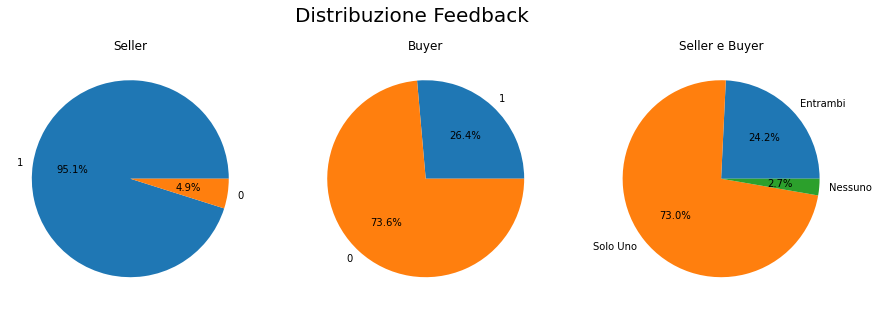

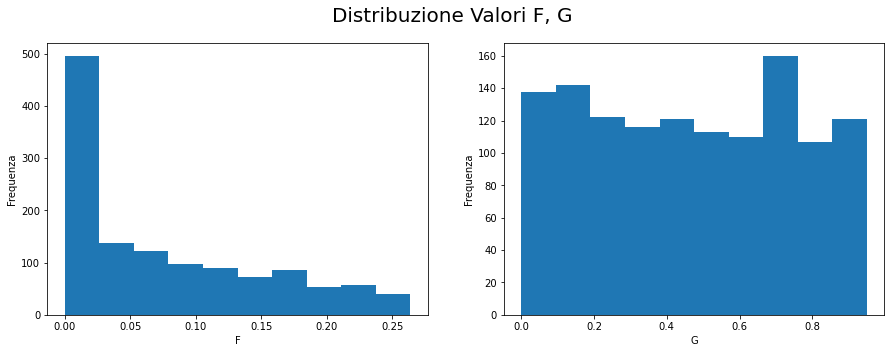

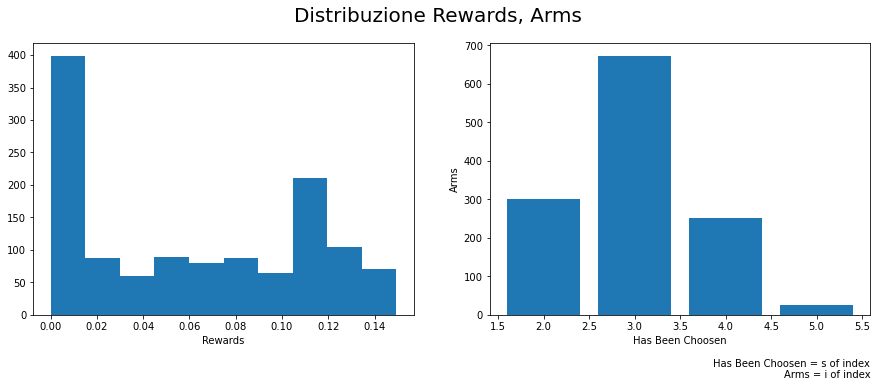

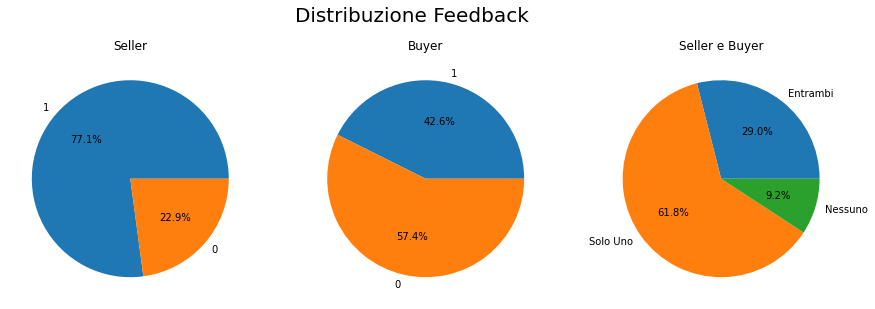

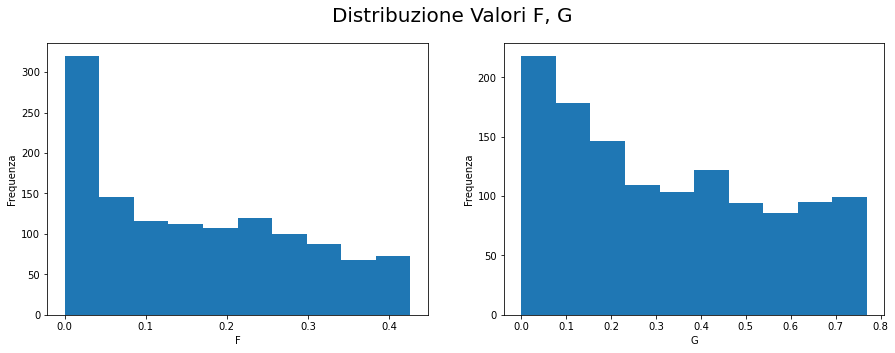

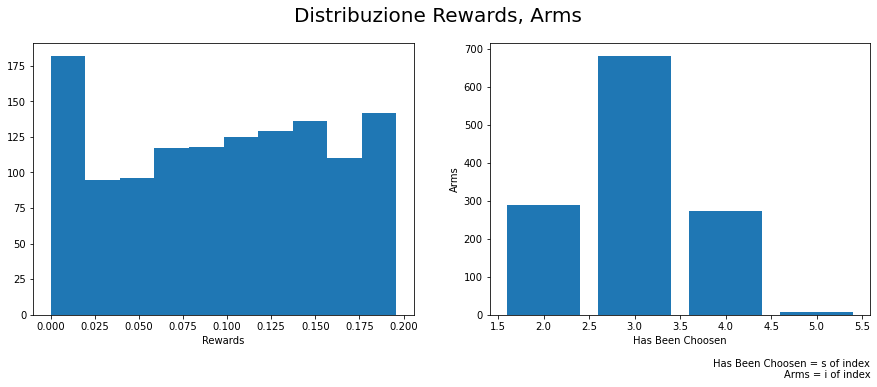

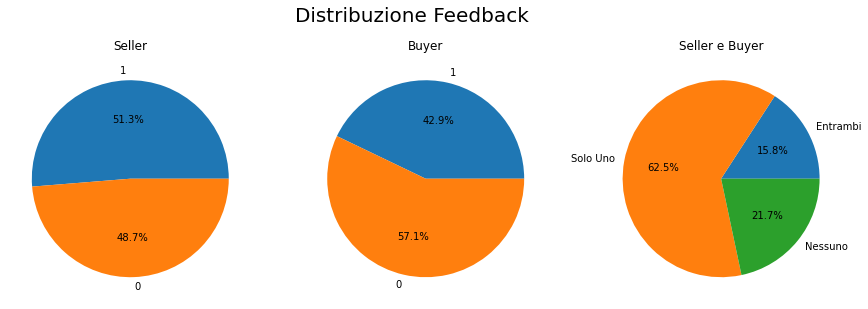

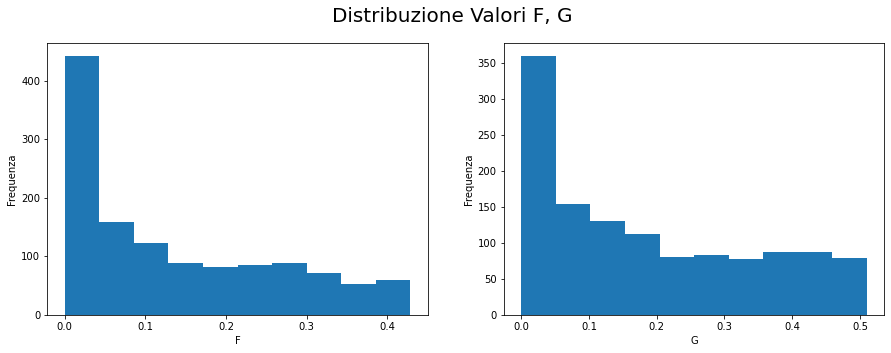

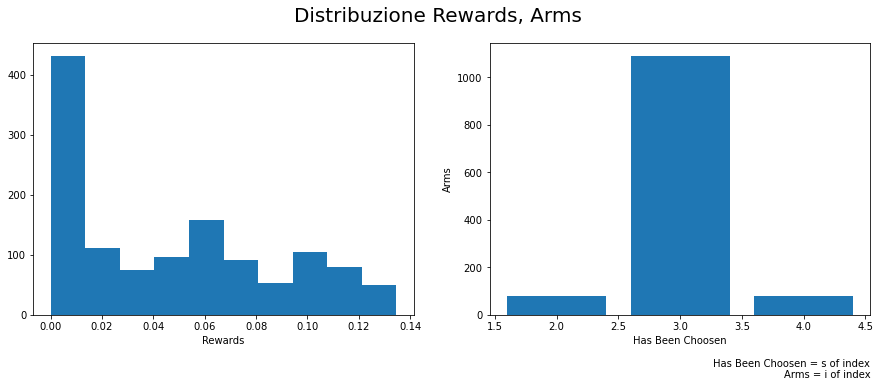

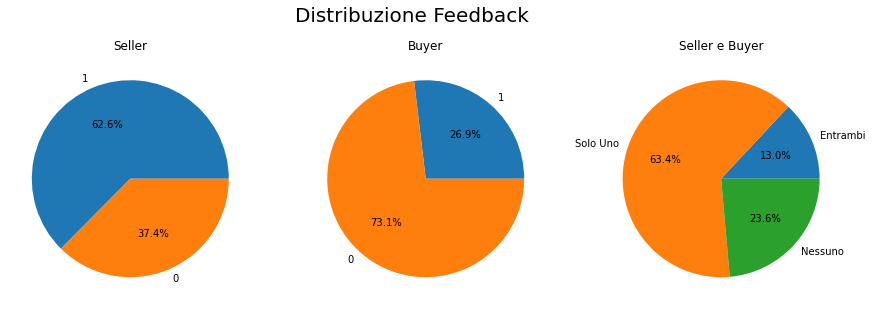

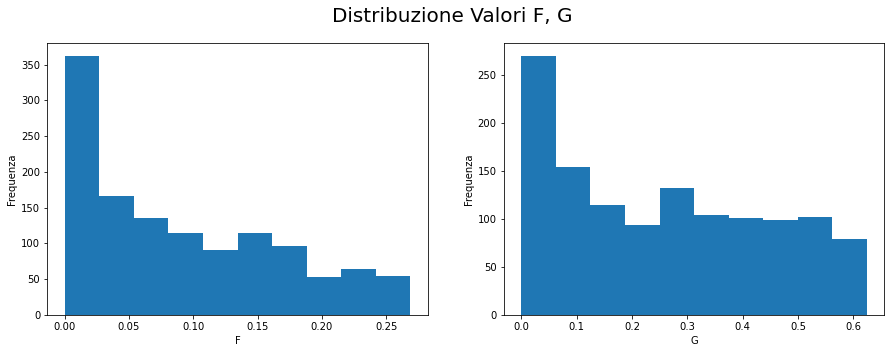

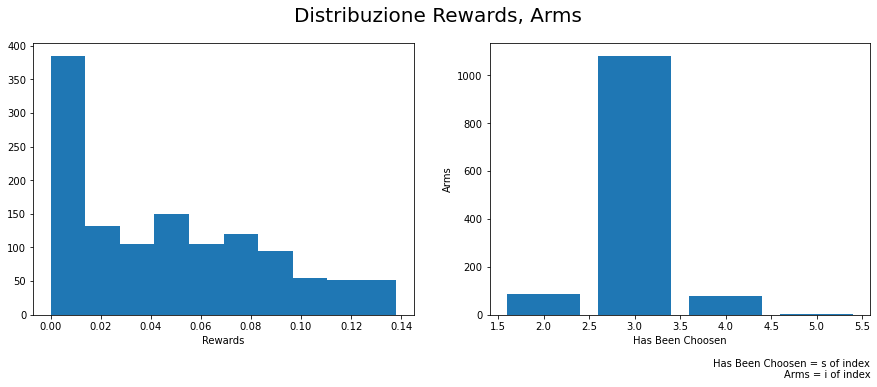

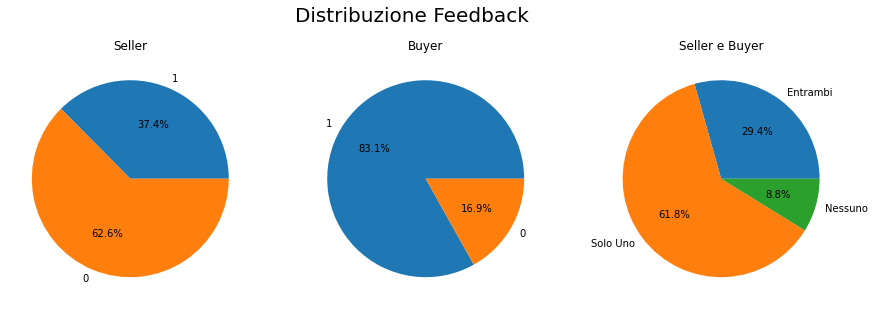

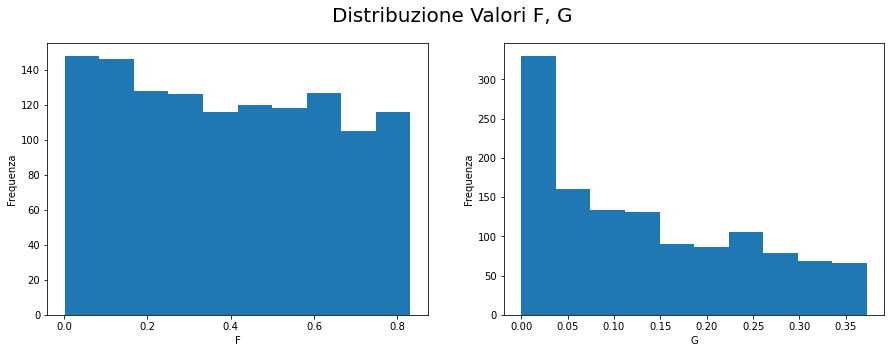

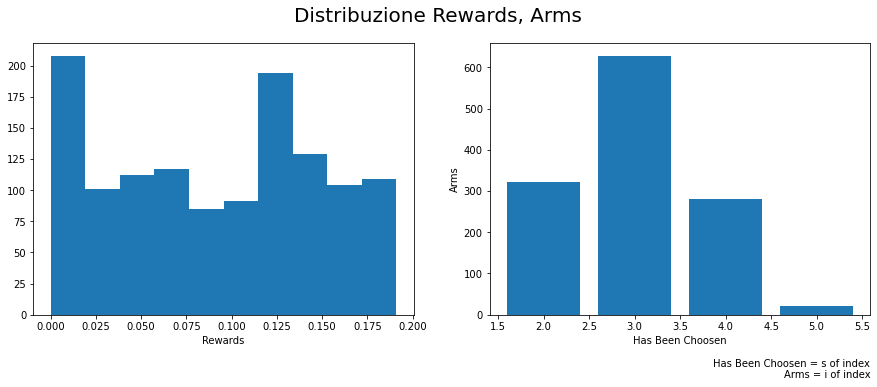

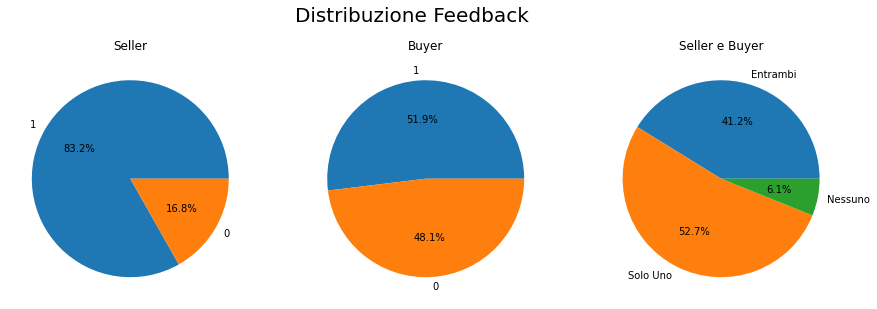

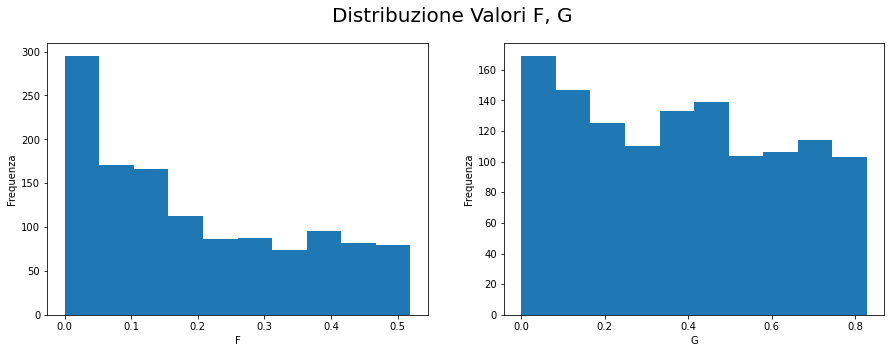

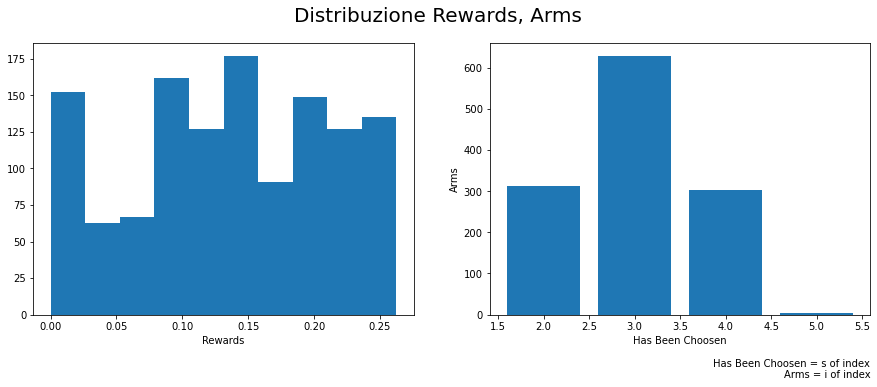

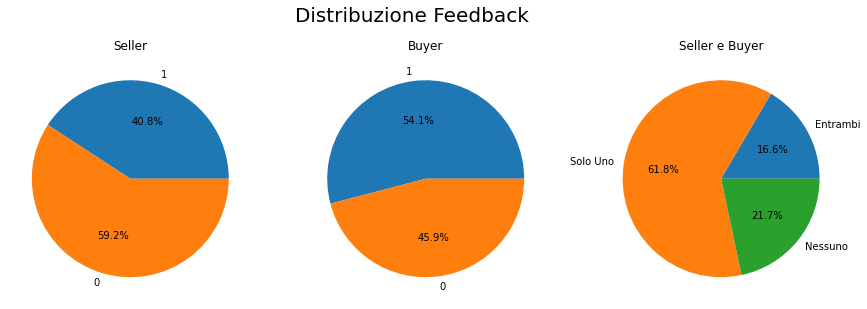

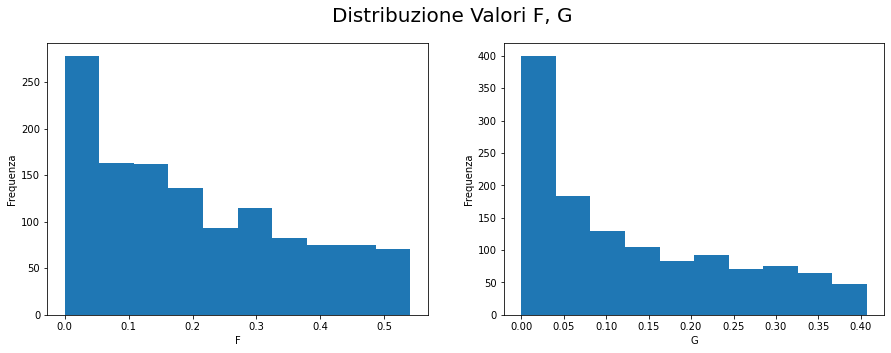

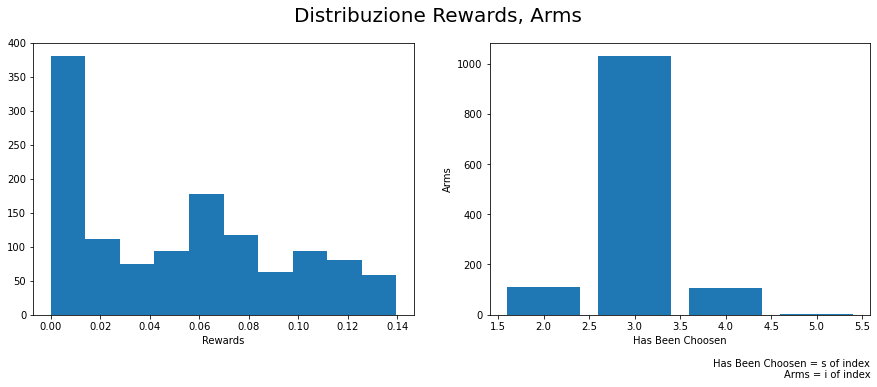

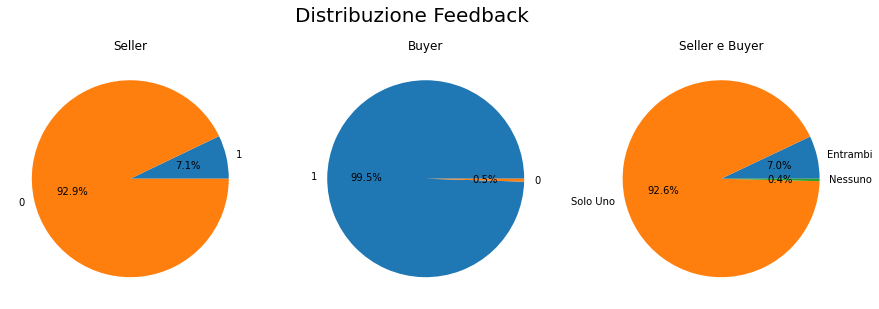

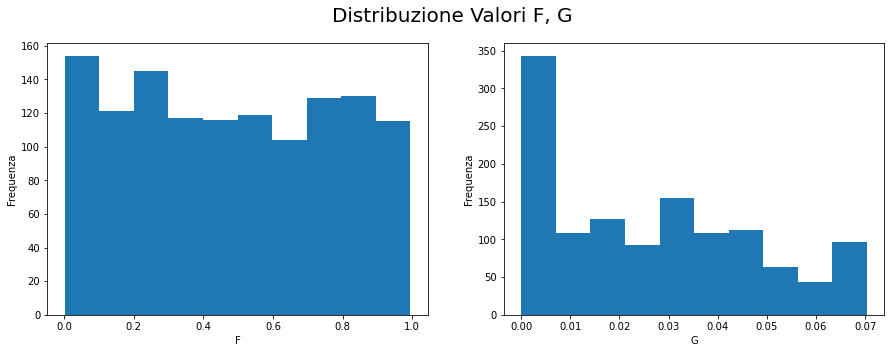

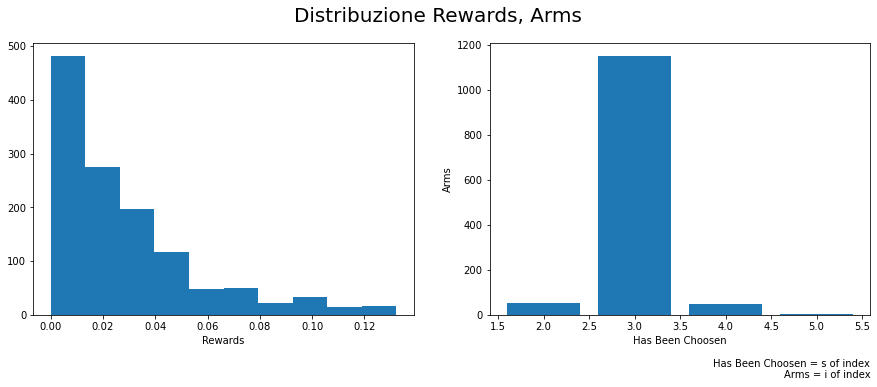

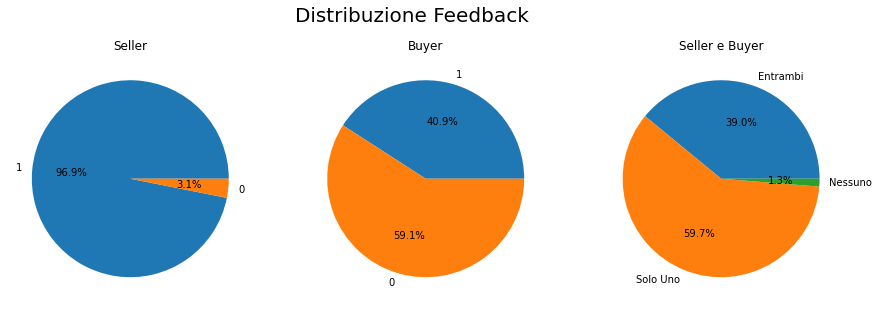

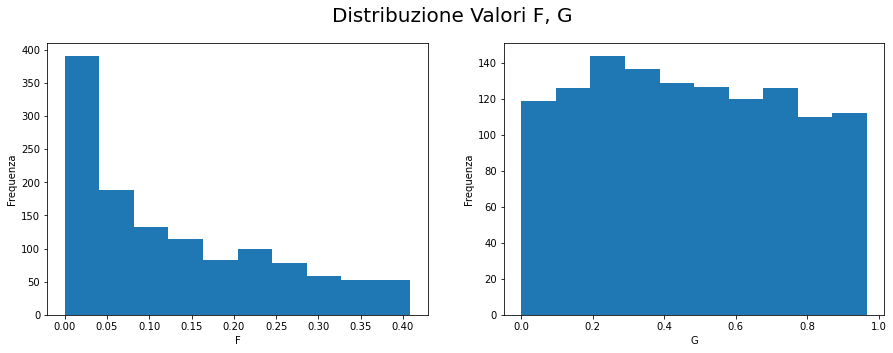

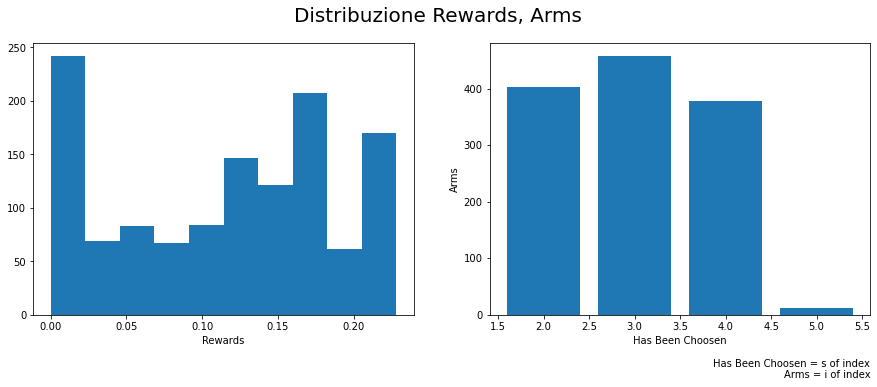

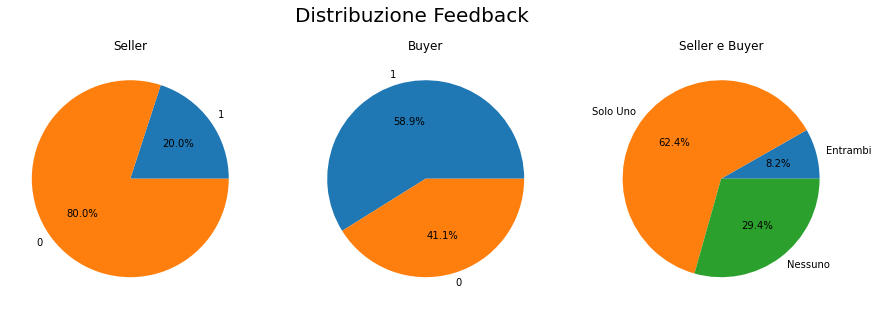

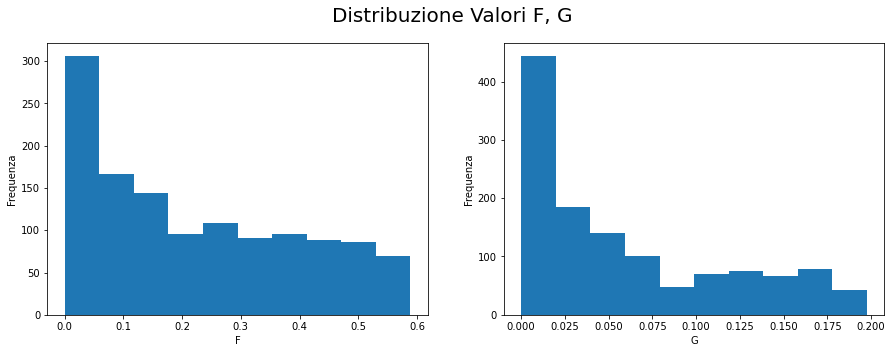

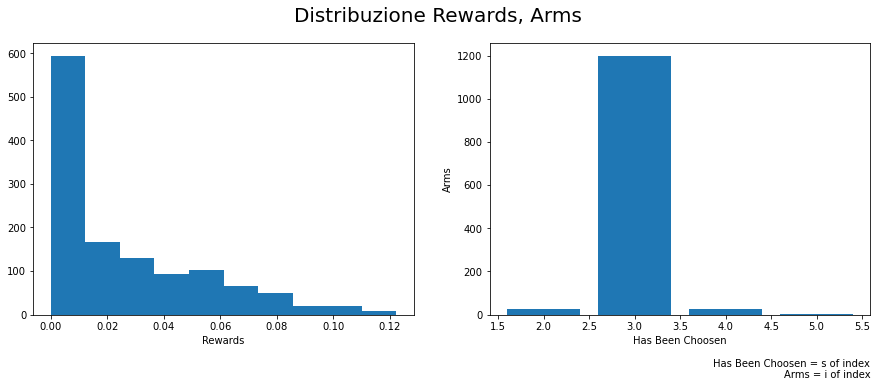

In [38]:
all_rewards = []
for i in range(n):
    arms, rewards = execute_algo(type_distribution,num_cifre,bandit_algorithm)
    all_rewards.append(rewards)

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def graph_rewards(rewards, K):
    tot_rewards = [rewards[0]]
    for i in range(1, len(rewards)):
        val = tot_rewards[i-1] + rewards[i]
        
        tot_rewards.append(val)

    x = np.linspace(0, len(tot_rewards), len(tot_rewards))
    regret = x**(2/3)

    plt.figure(figsize=(12, 6))

    # Subplot 1
    plt.subplot(1, 2, 1)
    plt.plot(x, regret, label='$T^{2/3}$', color='blue', linewidth=2)
    plt.plot(range(0, K), tot_rewards[:K], label="Rewards",color='green')
    plt.xlabel('x')
    plt.title('Grafico della funzione regret')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [61]:
import numpy as np
import matplotlib.pyplot as plt

def graph_rewards(rewards, K):
    len_rewards = len(rewards)
    x = np.linspace(0, len_rewards, len_rewards)
    regret = x**(2/3)

    plt.figure(figsize=(12, 6))

    # Subplot 1
    plt.subplot(1, 2, 1)
    plt.plot(x, regret, label='$T^{2/3}$', color='blue', linewidth=2)
    plt.plot(range(0, K), rewards[:K], label="Rewards",color='green')
    plt.xlabel('x')
    plt.title('Grafico della funzione regret')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [3]:
def get_median_rewards(all_rewards, K):
    result = [0] * K
    
    for j in range(n):
        values = [sum(all_rewards[j][:i]) for i in range(0, K)]
        result = [i+j for i,j in zip(values,result)]

    median_result = [x / n for x in result]
    return median_result


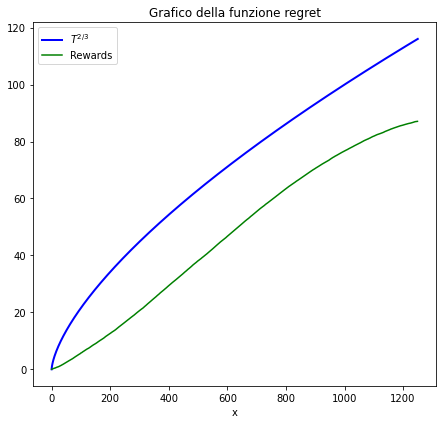

In [63]:
rewards = get_median_rewards(all_rewards, K)
graph_rewards(rewards, K)